In [1]:
! pip install pylibjpeg pylibjpeg-libjpeg pydicom
! pip install -U python-gdcm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 25.5 MB/s eta 0:00:00


<div style="color:white;display:fill;
            background-color: #A020F0;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>1 Libraries</b></p>
</div>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import cv2
import os
from os import listdir
import re
import gc
import gdcm
import pydicom
from pydicom import dcmread
import pylibjpeg
from pydicom.pixel_data_handlers.util import apply_voi_lut
import scipy.ndimage
from tqdm import tqdm
from pprint import pprint
from time import time
import itertools
from skimage import measure 
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import nibabel as nib
from glob import glob
import warnings
import dask.array as da
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import losses, callbacks
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image as im
%matplotlib inline
sns.set(style='darkgrid', font_scale=1.6)

<div style="color:white;display:fill;
            background-color: #A020F0;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>2 Activating Devices</b></p>
</div>

In [3]:
DEVICE = "GPU"
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

Using default strategy for CPU and single GPU
Num GPUs Available:  1
REPLICAS: 1


2022-08-30 18:54:17.942347: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 18:54:17.947224: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 18:54:17.948027: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


<div style="color:white;display:fill;
            background-color: #A020F0;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>3 Data</b></p>
</div>


In [4]:
#For Segmentation data
def load_NIfTI(path):
    mask = nib.load(path)
    
    # Convert to numpy array
    seg = mask.get_fdata()
    
    # Align orientation with images
    seg = seg[:, ::-1, ::-1].transpose(2, 1, 0)
    
    return seg

In [5]:
#Getting patient with mask
seg_paths = glob(f"../input/rsna-2022-cervical-spine-fracture-detection/segmentations/*")
training_patient=[]
for path in seg_paths:
    training_patient.append((path.rsplit("/",1)[-1])[:-4])#Patient with mask present

In [6]:
#Example segment image
path_mask=f"../input/rsna-2022-cervical-spine-fracture-detection/segmentations/{training_patient[0]}.nii"
patient_mask=load_NIfTI(path_mask)

patient_mask.shape

(195, 512, 512)

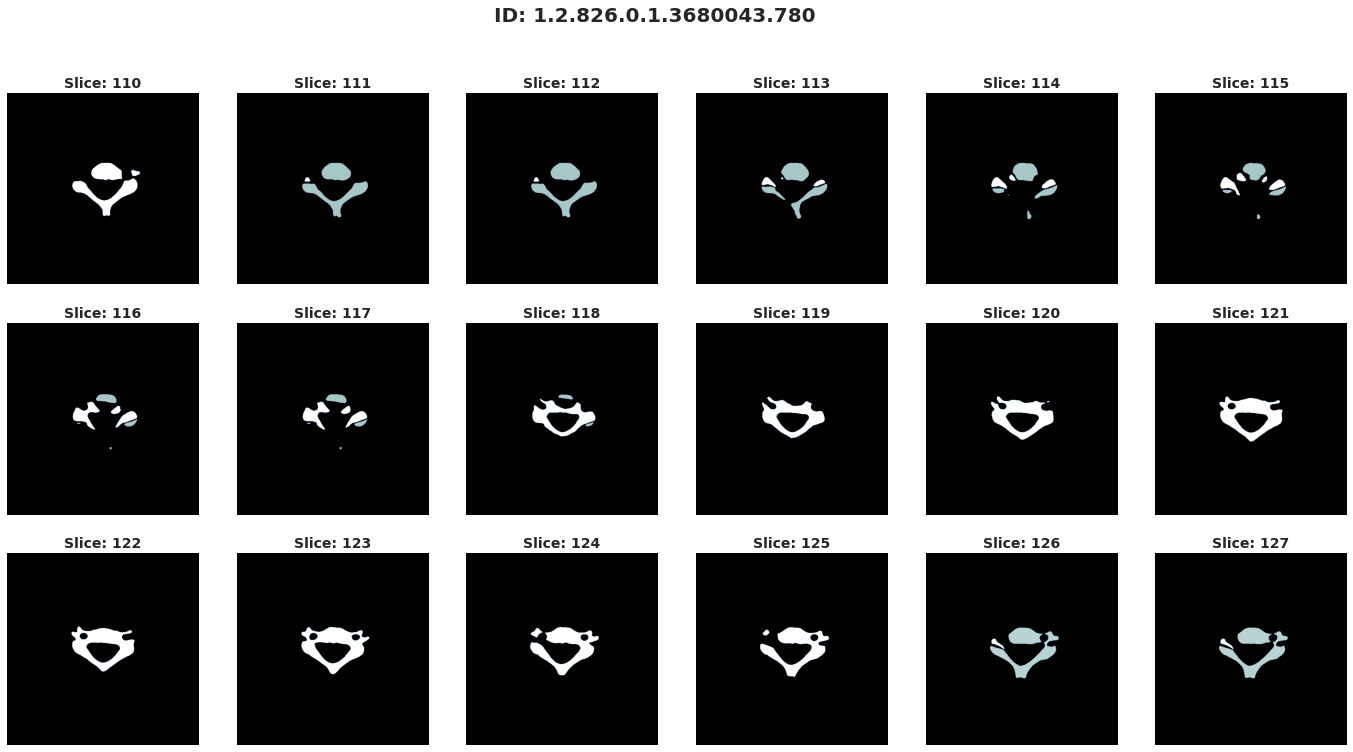

In [7]:
# Plot segment images
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(24,12))
fig.suptitle(f'ID: {training_patient[0]}', weight="bold", size=20)

start=110
for i in range(start,start+18):
    mask = patient_mask[i]
    slice_no = i

    # Plot the image
    x = (i-110) // 6
    y = (i-110) % 6

    axes[x, y].imshow(mask, cmap='bone')
    axes[x, y].set_title(f"Slice: {slice_no}", fontsize=14, weight='bold')
    axes[x, y].axis('off')

In [8]:
#Loading Scans
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [atoi(c) for c in re.split(r'(\d+)', text)]

# Load the scans in given folder path
def load_scan(path):
    
    dcm_paths = glob(f"{path}/*")
    dcm_paths.sort(key=natural_keys)
    
    patient_scan = [pydicom.dcmread(paths) for paths in dcm_paths]
    
    return patient_scan

In [9]:
#Example Scan
path_scan=f"../input/rsna-2022-cervical-spine-fracture-detection/train_images/{training_patient[0]}"
image=load_scan(path_scan)

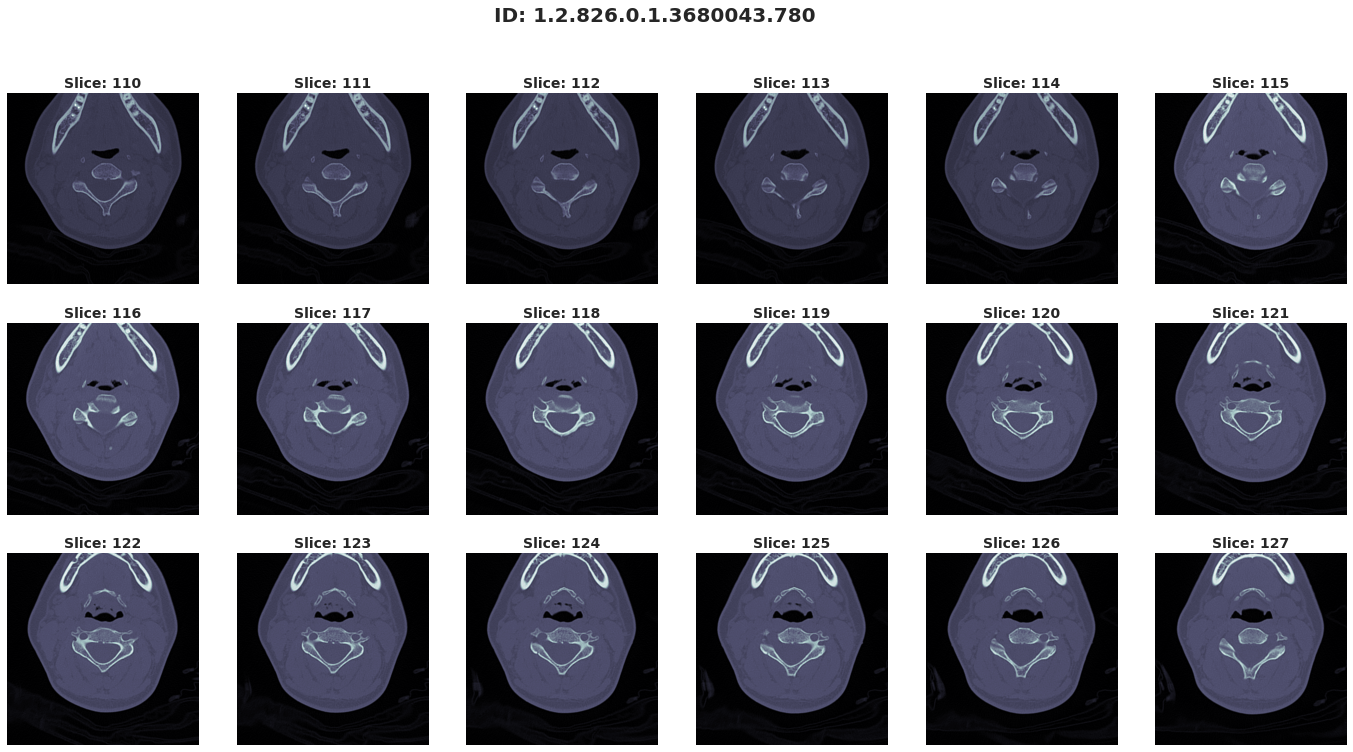

In [10]:
# Plot images
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(24,12))
fig.suptitle(f'ID: {training_patient[0]}', weight="bold", size=20)

start = 110
for i in range(start,start+18):
    img = image[i].pixel_array
    slice_no = i

    # Plot the image
    x = (i-start) // 6
    y = (i-start) % 6

    axes[x, y].imshow(img, cmap="bone")
    axes[x, y].set_title(f"Slice: {slice_no}", fontsize=14, weight='bold')
    axes[x, y].axis('off')

<div style="color:white;display:fill;
            background-color: #A020F0;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>4 Preprocessing</b></p>
</div>


<div style="color:white;display:fill;
            background-color: #A020F0;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>4.1 Loding and Conversion to HU</b></p>
</div>

In [11]:
def get_pixels_hu(slices):
   
    image = np.stack([cv2.resize(s.pixel_array,(512,512),interpolation = cv2.INTER_NEAREST) for s in slices])
    
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)
    image = da.from_array(image) #Using Dask to speed up processing
    
    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image <= -1000] = 0
    
    # Convert to Hounsfield units (HU)
        
    intercept = da.from_array([slices[slice_number].RescaleIntercept for slice_number in range(len(slices))])
    slope = da.from_array([slices[slice_number].RescaleSlope for slice_number in range(len(slices))])
    
    intercept=intercept.reshape((-1,1,1))
    slope=slope.reshape((-1,1,1))
    
    image= slope * image.astype("float64")
        
    image+= intercept
     
    return image.astype("int16")

In [12]:
patient_slice=get_pixels_hu(image)

(-0.5, 511.5, 511.5, -0.5)

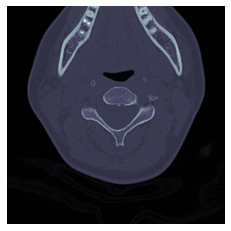

In [13]:
#Ploting pixel array
plt.imshow(image[110].pixel_array,cmap='bone')
plt.axis("off")

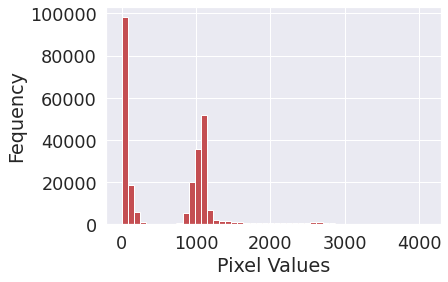

In [14]:
#Ploting pixel array distribution
plt.hist(image[110].pixel_array.flatten(),color="r",bins=50)
plt.xlabel("Pixel Values")
plt.ylabel("Fequency")
plt.show()

(-0.5, 511.5, 511.5, -0.5)

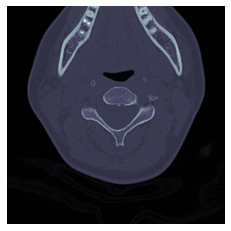

In [15]:
#Ploting HU array
plt.imshow(patient_slice[110],cmap='bone')
plt.axis("off")

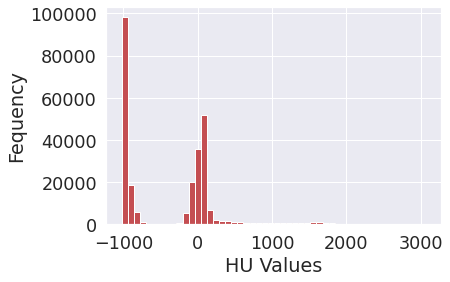

In [16]:
#Ploting HU distribution
plt.hist(patient_slice[110].flatten().compute(),color="r",bins=50)
plt.xlabel("HU Values")
plt.ylabel("Fequency")
plt.show()

<div style="color:white;display:fill;
            background-color: #A020F0;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>4.2 Normalization</b></p>
</div>

As HU values range from **150** to **2050**. So we will use this values for normalization.

In [17]:
MIN_BOUND = 150.0
MAX_BOUND = 2050.0
    
def normalize(image):
    image = (image - MIN_BOUND)*255.0 / (MAX_BOUND - MIN_BOUND)
    image[image>255] = 255.
    image[image<0] = 255.
    return image

In [18]:
image=normalize(patient_slice)

(-0.5, 511.5, 511.5, -0.5)

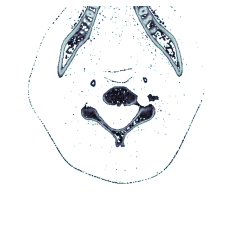

In [19]:
plt.imshow(image[110],cmap="bone")
plt.axis("off")

In [20]:
#Delete all unused objects to free up memory
del patient_slice
del image

gc.collect()

55928

<div style="color:white;display:fill;
            background-color: #A020F0;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>5 Model</b></p>
</div>

In [21]:
X_train_patient, X_Val_patient = train_test_split(training_patient,train_size=70,test_size=17,shuffle=True)

In [22]:
#Segreggate the preprocessed image in these folders based on Segmentation data in Training Folder.
def segregate_Train(start):
    
    train_ds_x=[]
    train_ds_y=[]
    for i in range(start,start+10):
        patient_ID=X_train_patient[i]
        
        patient_seg=load_NIfTI(f"../input/rsna-2022-cervical-spine-fracture-detection/segmentations/{patient_ID}.nii")
        
        patient_scan=load_scan(f"../input/rsna-2022-cervical-spine-fracture-detection/train_images/{patient_ID}")
        patient_hu=get_pixels_hu(patient_scan)
        patient_hu_normalised=normalize(patient_hu)
        
        for j in tqdm(range(0,len(patient_seg))):
            classes=np.unique(patient_seg[j])
        
            temp_lables=np.zeros(9)
            for k in classes:
                if int(k)!=0:
                    if int(k)<8:
                        temp_lables[int(k)]=1
                    else:
                        temp_lables[8]=1
                else:
                    temp_lables[0]=1
            
            train_ds_x.append(patient_hu_normalised[j].astype(np.uint8))
            train_ds_y.append(temp_lables.astype(np.uint8))
        
    return train_ds_x,train_ds_y

In [23]:
#Segreggate the preprocessed image in these folders based on Segmentation data in Training Folder.
def segregate_Val():
    
    val_ds_x=[]
    val_ds_y=[]
    for i in range(0,3):
        patient_ID=X_Val_patient[i]
        
        patient_seg=load_NIfTI(f"../input/rsna-2022-cervical-spine-fracture-detection/segmentations/{patient_ID}.nii")
        
        patient_scan=load_scan(f"../input/rsna-2022-cervical-spine-fracture-detection/train_images/{patient_ID}")
        patient_hu=get_pixels_hu(patient_scan)
        patient_hu_normalised=normalize(patient_hu)
        
        for j in tqdm(range(0,len(patient_seg))):
            classes=np.unique(patient_seg[j])
        
            temp_lables=np.zeros(9)
            for k in classes:
                if int(k)!=0:
                    if int(k)<8:
                        temp_lables[int(k)]=1
                    else:
                        temp_lables[8]=1
                else:
                    temp_lables[0]=1
            
            val_ds_x.append(patient_hu_normalised[j].astype(np.uint8))
            val_ds_y.append(temp_lables.astype(np.uint8))
        
    return val_ds_x,val_ds_y

In [24]:
#Call this in a loop to train the model in folds
train_ds_x,train_ds_y=segregate_Train(0)
val_ds_x,val_ds_y=segregate_Val()

100%|██████████| 263/263 [00:01<00:00, 159.48it/s]


In [25]:
#Convert into specific format from tensorflow model
train_ds_x=np.array(train_ds_x)
train_ds_y=np.array(train_ds_y)
val_ds_x=np.array(val_ds_x)
val_ds_y=np.array(val_ds_y)

In [26]:
print(train_ds_x.shape)
print(train_ds_y.shape)
print(val_ds_x.shape)
print(val_ds_y.shape)

(2870, 512, 512)
(2870, 9)
(1187, 512, 512)
(1187, 9)


In [27]:
train_ds_x=np.reshape(train_ds_x,(-1,512,512,1))
val_ds_x=np.reshape(val_ds_x,(-1,512,512,1))

In [28]:
print(train_ds_x.shape)
print(train_ds_y.shape)
print(val_ds_x.shape)
print(val_ds_y.shape)

(2870, 512, 512, 1)
(2870, 9)
(1187, 512, 512, 1)
(1187, 9)


In [29]:
print(train_ds_y[170])

[1 0 0 0 1 1 0 0 0]


(-0.5, 511.5, 511.5, -0.5)

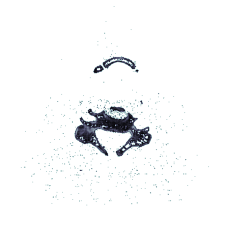

In [30]:
plt.imshow(train_ds_x[170],cmap="bone")
plt.axis("off")

In [31]:
gc.collect()

2254

In [32]:
#Data augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(train_ds_x)

In [33]:
#Defining the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (512,512,1)),
    tf.keras.layers.Conv2D(filters = 8, kernel_size = (3,3), activation ='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.30),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (7,7),padding = 'Same', activation ='relu'),
    tf.keras.layers.Conv2D(filters = 8, kernel_size = (5,5), activation ='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(4, 4)),
    tf.keras.layers.Dropout(0.30),
    tf.keras.layers.Conv2D(filters = 8, kernel_size = (7,7),padding = 'Same', activation ='relu'),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (5,5), activation ='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(6, 6)),
    tf.keras.layers.Dropout(0.30),
    tf.keras.layers.Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', activation ='relu'),
    tf.keras.layers.Conv2D(filters = 16, kernel_size = (7,7), activation ='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(3, 3)),
    tf.keras.layers.Dropout(0.30),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(12,activation="ReLU"),
    tf.keras.layers.Dense(9, activation='softmax')
])
model.build([None, 512, 512, 1])
model.summary()

2022-08-30 20:31:33.371581: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 512, 512, 64)      1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 510, 510, 8)       4616      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 255, 255, 8)       0         
_________________________________________________________________
dropout (Dropout)            (None, 255, 255, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 255, 255, 64)      25152     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 251, 251, 8)       12808     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 8)         0

2022-08-30 20:31:33.372279: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 20:31:33.373127: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 20:31:33.373823: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 20:31:35.734626: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 20:31:35.735433: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [34]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [35]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [36]:
history=model.fit(datagen.flow(train_ds_x,train_ds_y),epochs=50,use_multiprocessing=True,shuffle=True,callbacks=[early_stopping],validation_data=(val_ds_x,val_ds_y))

2022-08-30 20:31:37.855826: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-08-30 20:31:41.004623: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


90/90 [==============================] - 81s 759ms/step - loss: 0.8140 - accuracy: 0.5331 - val_loss: 0.5704 - val_accuracy: 1.0000
Epoch 2/50
90/90 [==============================] - 70s 771ms/step - loss: 0.5121 - accuracy: 0.8746 - val_loss: 0.5049 - val_accuracy: 1.0000
Epoch 3/50
90/90 [==============================] - 75s 827ms/step - loss: 0.4767 - accuracy: 0.9063 - val_loss: 0.5025 - val_accuracy: 1.0000
Epoch 4/50
90/90 [==============================] - 79s 862ms/step - loss: 0.4590 - accuracy: 0.9627 - val_loss: 0.4775 - val_accuracy: 1.0000
Epoch 5/50
90/90 [==============================] - 77s 844ms/step - loss: 0.4475 - accuracy: 0.9955 - val_loss: 0.4736 - val_accuracy: 1.0000
Epoch 6/50
90/90 [==============================] - 70s 777ms/step - loss: 0.4384 - accuracy: 0.9962 - val_loss: 0.4672 - val_accuracy: 1.0000
Epoch 7/50
90/90 [==============================] - 73s 813ms/step - loss: 0.4269 - accuracy: 0.9979 - val_loss: 0.4588 - val_accuracy: 1.0000
Epoch 8/50

Minimum validation loss: 0.38396140933036804


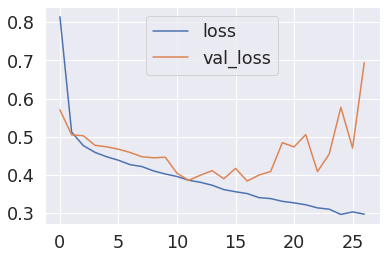

In [37]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

In [38]:
model.save("Classifier.h5")